Consider the following matrix \( X \in \mathbb{R}^{400 \times 400} \) defined as:

\[ 
X_{ij} = 
\begin{cases} 
110 & 50 \leq i \leq 150, 30 \leq j \leq 130, \\ 
150 & 50 \leq i \leq 150, 230 \leq j \leq 330, \\ 
180 & 250 \leq i \leq 350, 70 \leq j \leq 170, \\ 
220 & 250 \leq i \leq 350, 270 \leq j \leq 370, \\ 
0 & \text{elsewhere}
\end{cases} 
\]

where \( i, j = 1, \ldots, 400 \).

1. Add a synthetic noise by sampling from a Gaussian distribution with zero mean and standard deviation \(\sigma = 0.2\).

2. Implement the singular value truncation (SVT) algorithm and apply it to reconstruct the original matrix \( X \) from \( X_{noise} \). Set a maximum number of iterations equal to 50, a tolerance on the increment equal to \(10^{-6}\) and try to optimize the threshold on the singular values by trial and error. Compute the relative reconstruction error between \( X \) and the approximation \( \hat{X} \), defined as:

\[ 
\epsilon_R = \frac{\|X - \hat{X}\|_F}{\|X\|_F}, 
\]

the rank \( \hat{r} \) of \( \hat{X} \) and visualize the true image and its approximation.

3. Find, by means of exact SVD, the value of \( k \) providing a relative reconstruction error equal to the one obtained in the previous point. Comment the results.

4. Repeat the previous point by means of randomized SVD. Comment the results.


In [79]:
import numpy as np
import matplotlib.pyplot as plt 

1. Add a synthetic noise by sampling from a Gaussian distribution with zero mean and standard deviation \(\sigma = 0.2\).

In [80]:
def addValueToMatrixWithSomeNoises(matrix, startIndexRow, endIndexRow, startIndexCol, endIndexCol, value):
    noise = 0.2

    nRows = matrix.shape[0]
    nCols = matrix.shape[1]
    if(startIndexRow == 0 or startIndexRow == 0):
        return
    if(startIndexRow >= endIndexRow):
        return
    elif(startIndexCol >= endIndexCol):
        return
    elif(endIndexRow > nRows):
        return
    elif(endIndexCol > nCols):
        return
    startIndexRow = startIndexRow - 1
    endIndexRow = endIndexRow - 1
    startIndexCol = startIndexCol - 1
    endIndexCol = endIndexCol - 1

    for i in range(startIndexRow, endIndexRow):
        for j in range(startIndexCol, endIndexCol):
            matrix[i,j] = value + noise * np.random.randn()

def addValueToMatrix(matrix, startIndexRow, endIndexRow, startIndexCol, endIndexCol, value):

    nRows = matrix.shape[0]
    nCols = matrix.shape[1]
    if(startIndexRow == 0 or startIndexRow == 0):
        return
    if(startIndexRow >= endIndexRow):
        return
    elif(startIndexCol >= endIndexCol):
        return
    elif(endIndexRow > nRows):
        return
    elif(endIndexCol > nCols):
        return
    startIndexRow = startIndexRow - 1
    endIndexRow = endIndexRow - 1
    startIndexCol = startIndexCol - 1
    endIndexCol = endIndexCol - 1

    for i in range(startIndexRow, endIndexRow):
        for j in range(startIndexCol, endIndexCol):
            matrix[i,j] = value


In [81]:
def rsvd(A, k):
    m,n = A.shape
    omega = np.random.randn(n, k)
    Y = A @ omega
    Q , R = np.linalg.qr(Y)
    B = Q.T @ A
    Ub, s, VT = np.linalg.svd(B, full_matrices= False)
    U = Q @ Ub
    return U, s, VT 

In [82]:
# first of all we need to reconstruct that matrix
n = 400

X = np.zeros((n, n))

addValueToMatrix(X, 50, 150, 30, 130, 110)
addValueToMatrix(X, 50, 150, 230, 330, 150)
addValueToMatrix(X, 250, 350, 70, 170, 180)
addValueToMatrix(X, 350, 350, 270, 370, 220)

print(X[49, 29])

X_noise = np.zeros((n, n))

addValueToMatrixWithSomeNoises(X_noise, 50, 150, 30, 130, 110)
addValueToMatrixWithSomeNoises(X_noise, 50, 150, 230, 330, 150)
addValueToMatrixWithSomeNoises(X_noise, 250, 350, 70, 170, 180)
addValueToMatrixWithSomeNoises(X_noise, 350, 350, 270, 370, 220)

print(X_noise[49, 29])

110.0
110.03267026651285


4.962843801615095
3.8537556596143445
36409.238472431534


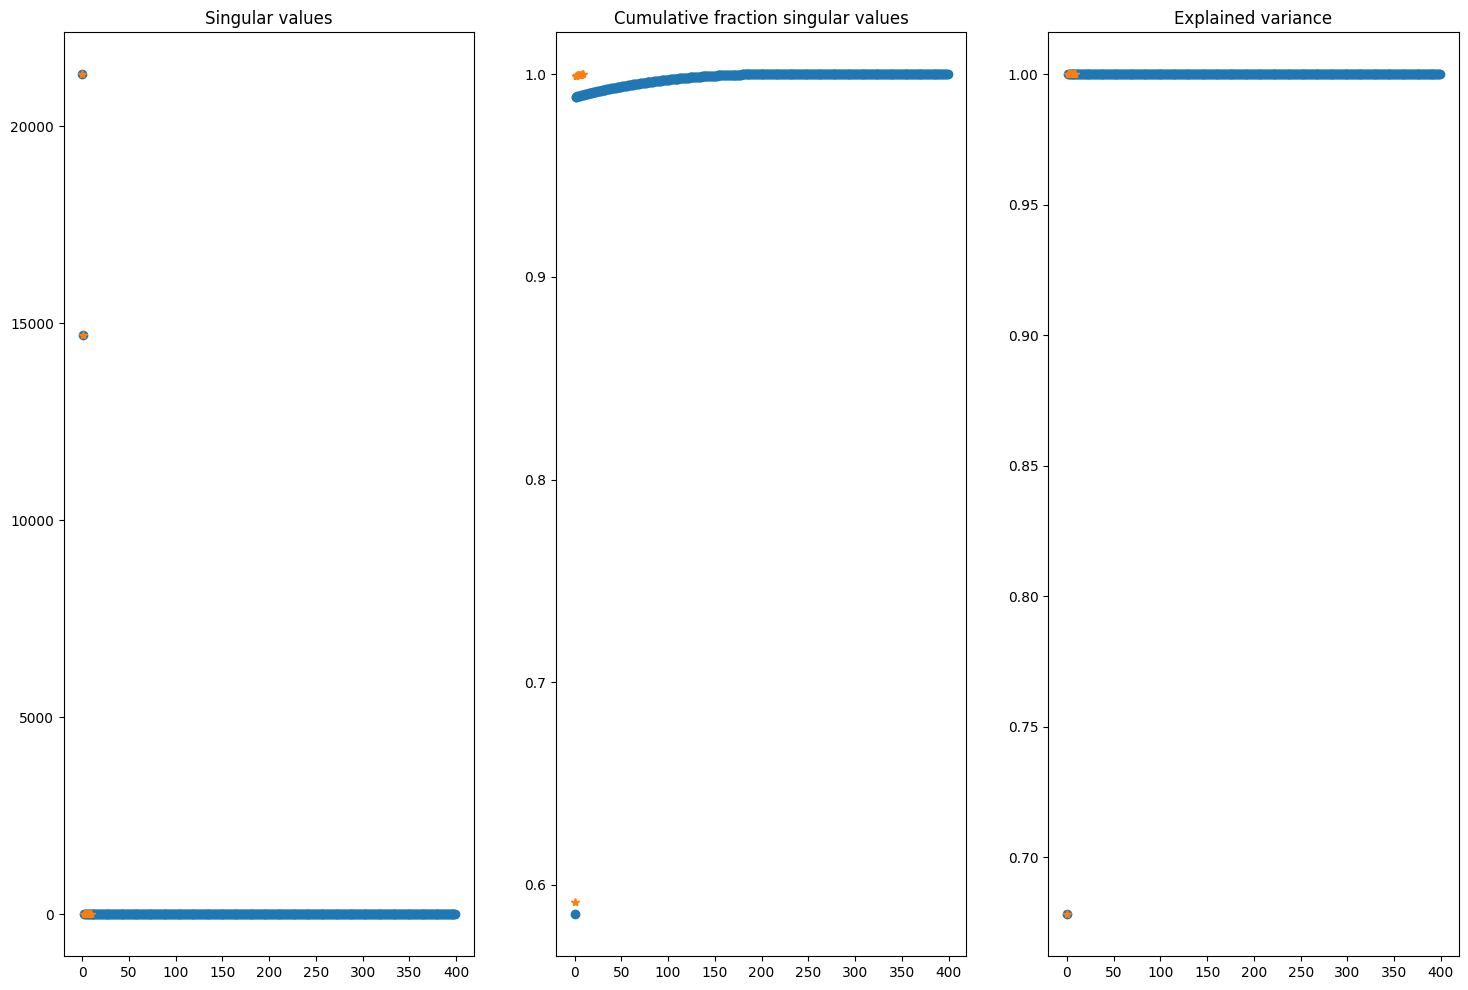

In [92]:
U, s_rand, VT = rsvd(X_noise, 10)
U, s, VT = np.linalg.svd(X_noise, full_matrices= False)

fig, axs = plt.subplots(1,3, figsize = (18,12))

axs[0].plot(s, 'o')
axs[0].plot(s_rand, '*')
axs[0].set_title("Singular values")

axs[1].plot(np.cumsum(s) / np.sum(s), 'o')
axs[1].plot(np.cumsum(s_rand) / np.sum(s_rand), '*')
axs[1].set_title("Cumulative fraction singular values")

axs[2].plot(np.cumsum(s**2) / np.sum(s**2), 'o')
axs[2].plot(np.cumsum(s_rand**2) / np.sum(s_rand**2), '*')
axs[2].set_title("Explained variance")

print(s[2])
print(s_rand[2])

print(np.sum(s))

# the most important singular values are the first and second ones

2. Implement the singular value truncation (SVT) algorithm and apply it to reconstruct the original matrix \( X \) from \( X_{noise} \). Set a maximum number of iterations equal to 50, a tolerance on the increment equal to \(10^{-6}\) and try to optimize the threshold on the singular values by trial and error. Compute the relative reconstruction error between \( X \) and the approximation \( \hat{X} \), defined as:

\[ 
\epsilon_R = \frac{\|X - \hat{X}\|_F}{\|X\|_F}, 
\]

the rank \( \hat{r} \) of \( \hat{X} \) and visualize the true image and its approximation.

In [102]:

# Singular value truncation (SVT) algorithm
def svt(X_noise, threshold, max_iter=50, tolerance=1e-6):
    X_hat = X_noise.copy()
    for k in range(max_iter):
        X_hat_old = X_hat.copy()
        U, s, VT = np.linalg.svd(X_hat_old, full_matrices=False)
        s[s < threshold] = 0
        print(s)
        X_hat = U @ np.diag(s) @ VT
        increment = np.linalg.norm(X_hat - X_hat_old)
        if increment < tolerance:
            break
    return X_hat, k, s

In [103]:
# Optimize threshold by trial and error
thresholds = [1, 2, 3, 4, 5, 10, 50, 100, 150, 200]
best_threshold = thresholds[0]
best_error = float('inf')
best_X_hat = None

In [104]:
for threshold in thresholds:
    X_hat, iter_count, s_hat = svt(X_noise, threshold)
    error = np.linalg.norm(X - X_hat, 'fro') / np.linalg.norm(X, 'fro')
    if error < best_error:
        best_error = error
        best_threshold = threshold
        best_X_hat = X_hat
        best_s_hat = s_hat

print(f'Best threshold: {best_threshold}, Best error: {best_error}')

[2.13145024e+04 1.46865143e+04 4.96284380e+00 4.80415318e+00
 4.73085161e+00 4.68025529e+00 4.60928385e+00 4.55270916e+00
 4.51476570e+00 4.46369670e+00 4.45942188e+00 4.39167336e+00
 4.33928928e+00 4.26269809e+00 4.23464684e+00 4.20666511e+00
 4.13768201e+00 4.08385639e+00 4.07793065e+00 4.05515070e+00
 3.97466228e+00 3.93674692e+00 3.89236963e+00 3.87481052e+00
 3.86626437e+00 3.80890956e+00 3.80222367e+00 3.72082168e+00
 3.69828141e+00 3.68487451e+00 3.63711469e+00 3.62850054e+00
 3.58673142e+00 3.54797142e+00 3.53785942e+00 3.49509632e+00
 3.47070656e+00 3.43173770e+00 3.40363732e+00 3.36923074e+00
 3.33586747e+00 3.32686829e+00 3.28928289e+00 3.22193844e+00
 3.21354483e+00 3.19538059e+00 3.12918602e+00 3.09765536e+00
 3.08026506e+00 3.04577364e+00 3.03347098e+00 3.00670109e+00
 2.99450604e+00 2.98300191e+00 2.95307501e+00 2.92738643e+00
 2.88005921e+00 2.85297891e+00 2.84421901e+00 2.82975692e+00
 2.78931725e+00 2.76807801e+00 2.75419688e+00 2.75000465e+00
 2.72884791e+00 2.685524

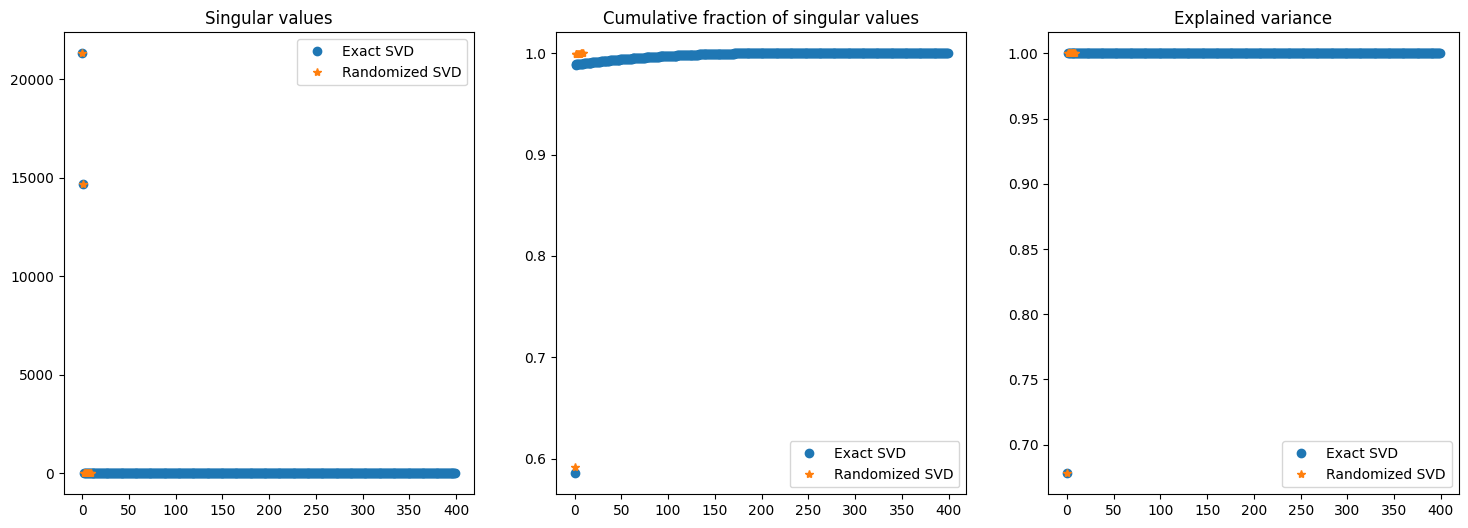

Number of iterations: 1
Relative reconstruction error: 0.00018380599390459292


In [105]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].plot(s, 'o', label='Exact SVD')
axs[0].plot(s_rand, '*', label='Randomized SVD')
axs[0].set_title('Singular values')
axs[0].legend()

axs[1].plot(np.cumsum(s) / np.sum(s), 'o', label='Exact SVD')
axs[1].plot(np.cumsum(s_rand) / np.sum(s_rand), '*', label='Randomized SVD')
axs[1].set_title('Cumulative fraction of singular values')
axs[1].legend()

axs[2].plot(np.cumsum(s**2) / np.sum(s**2), 'o', label='Exact SVD')
axs[2].plot(np.cumsum(s_rand**2) / np.sum(s_rand**2), '*', label='Randomized SVD')
axs[2].set_title('Explained variance')
axs[2].legend()

plt.show()
# Output the relative reconstruction error and the number of iterations
print(f'Number of iterations: {iter_count}')
print(f'Relative reconstruction error: {best_error}')

the rank \( \hat{r} \) of \( \hat{X} \) and visualize the true image and its approximation.

Rank of X̂: 2


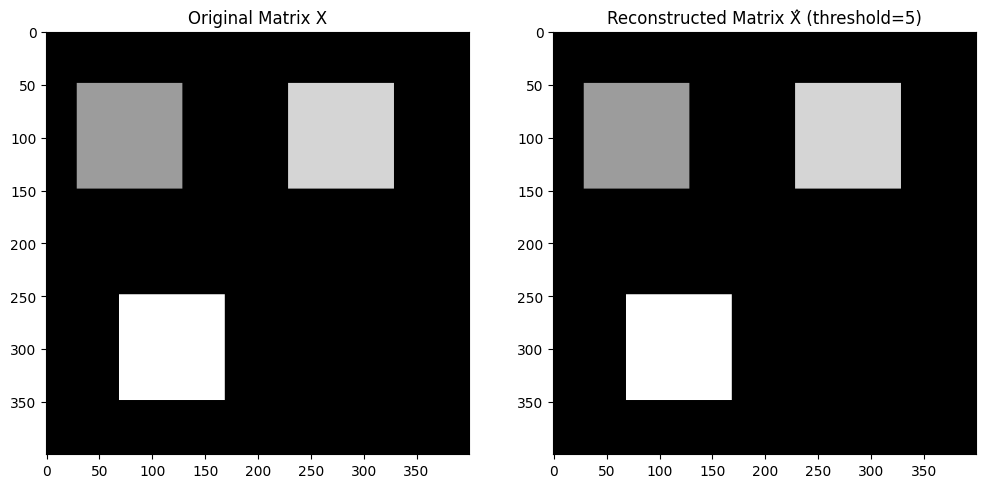

array([21314.50236546, 14686.5143209 ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
      

In [106]:
# Calculate the rank r̂ of X̂
rank_hat = np.sum(best_s_hat > 0)
print(f'Rank of X̂: {rank_hat}')

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(X, cmap='gray')
axs[0].set_title('Original Matrix X')

axs[1].imshow(best_X_hat, cmap='gray')
axs[1].set_title(f'Reconstructed Matrix X̂ (threshold={best_threshold})')

plt.show()